In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/irf_model/')

from Dataset_Creation import sys_dataset


In [2]:
figformat = 'svg'

In [3]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/irf_model/config.json") as json_data_file:

    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}


In [4]:
biass = [0.0]
sigmass = [1e-12, 1e-2, 0.5, 0.8]


In [5]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = 0, 
                        sigma = s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['tilt_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['bias'].frozen  = True
    #dataset_conv_N.models.parameters['resolution'].frozen  = True
    #dataset_conv_N.models.parameters['resolution'].value  = s
    dataset_conv_N.e_reco_n = 1
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4, 4))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/s**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

datasets_conv =[]
datasets_conv_N =[]
datasets_conv_N_fine = []

for s in sigmass:
    dataset_conv, dataset_conv_N , dataset_conv_N_fine = create_dataset(biass[0], s)
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    datasets_conv_N_fine.append(dataset_conv_N_fine)
    
#datasets_conv = Datasets(datasets_conv)
#datasets_conv_N = Datasets(datasets_conv_N)
#datasets_conv_N_fine = Datasets(datasets_conv_N_fine)


in map: 1e-12
evaluate: 1e-12 0.0
10
in map: 1e-12
evaluate: 1e-12 0.0
10
in map: 1e-12
evaluate: 1e-12 0.0
10
in map: 0.01
evaluate: 0.01 0.0
10
in map: 0.01
evaluate: 0.01 0.0
10
in map: 0.01
evaluate: 0.01 0.0
10
in map: 0.5
evaluate: 0.5 0.0
10
in map: 0.5
evaluate: 0.5 0.0
10
in map: 0.5
evaluate: 0.5 0.0
10
in map: 0.8
evaluate: 0.8 0.0
10
in map: 0.8
evaluate: 0.8 0.0
10
in map: 0.8
evaluate: 0.8 0.0
10


In [6]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

in map: 0.0
evaluate: 0.0 0.0
1


<WCSAxesSubplot: >

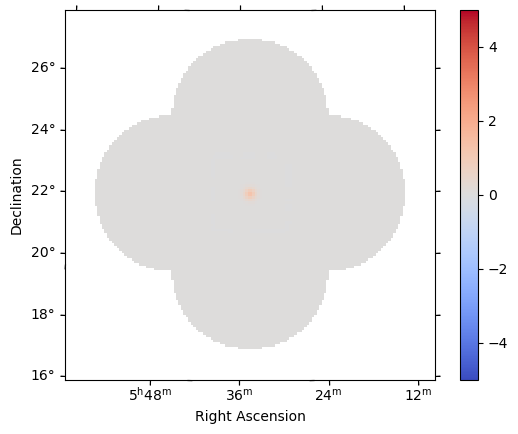

In [7]:
d = dataset_conv_N
d.plot_residuals_spatial()

in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
1


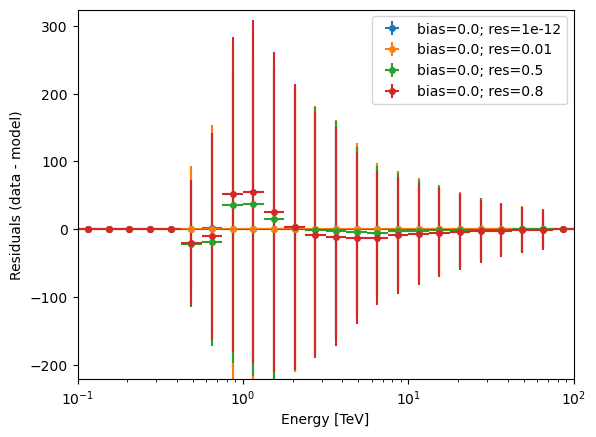

In [8]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        #d = datasets_conv_N_fine[i]
        #d.plot_residuals_spectral(ax =ax, color= colors[1], 
        #            label = f"bias={b}; res={s}")
        i += 1
ax.legend()


In [9]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10


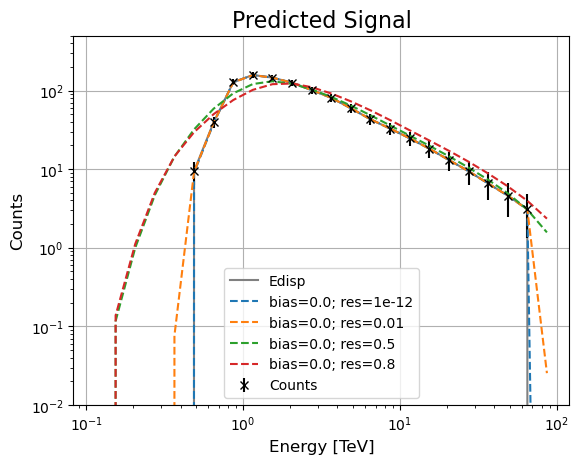

In [10]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(energy,sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
plt.errorbar(energy, sum_e(d.counts.data-d.background.data), 
             yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
            fmt = 'x', label = "Counts", color = 'black')

for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        npreds_pre_fit_N_fine.append( sum_e(datasets_conv_N_fine[i].npred_signal().data))
        
        plt.plot( energy, sum_e(datasets_conv[i].npred_signal().data),
                 '--', label = f"bias={b}; res={s}",)# color = colors[i])
        #plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
        #         'x', label = f"bias={b}; res={s}", color = colors[i])
        #plt.plot( sum_e(datasets_conv_N_fine[i].npred_signal().data),
        #         '--', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.loglog()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Energy [TeV]", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.grid(True)
plt.ylim(1e-2, 5e2)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 132              │
│ EDM = 2.11e-08 (Goal: 2e-06)     │            time = 1.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 130              │
│ EDM = 5.15e-07 (Goal: 2e-06)     │            time = 1.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.00203

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.00203

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.00203

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.00203

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.00203

in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 128              │
│ EDM = 1.77e-06 (Goal: 2e-06)     │           time = 26.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit  

'for d in datasets_conv_N_fine:\n    fit_cor_N_fine = Fit(store_trace=True)\n    fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}\n    result_cor_N_fine = fit_cor_N_fine.run(d)\n    d.models.covariance = fit_cor_N_fine.covariance(d).matrix\n    d.models.covariance.plot_correlation()\n    print(fit_cor_N_fine.minuit)\n\n\n'

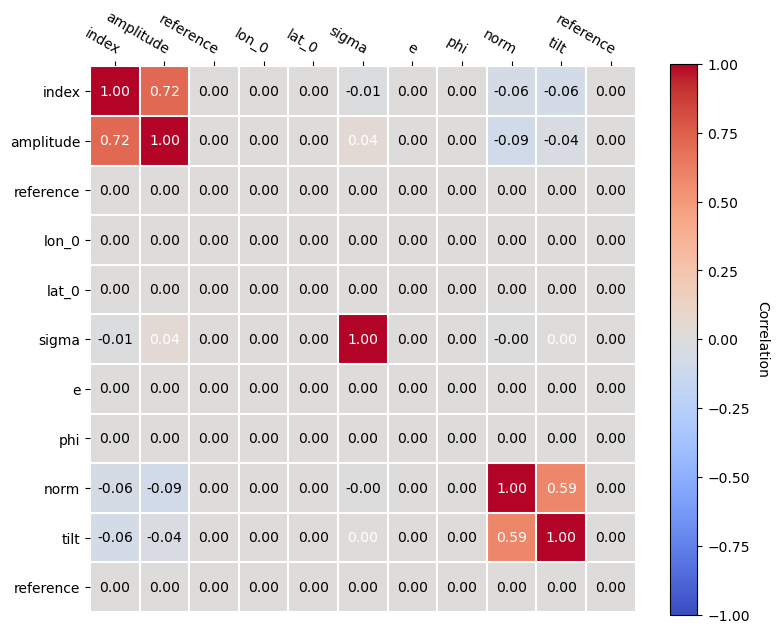

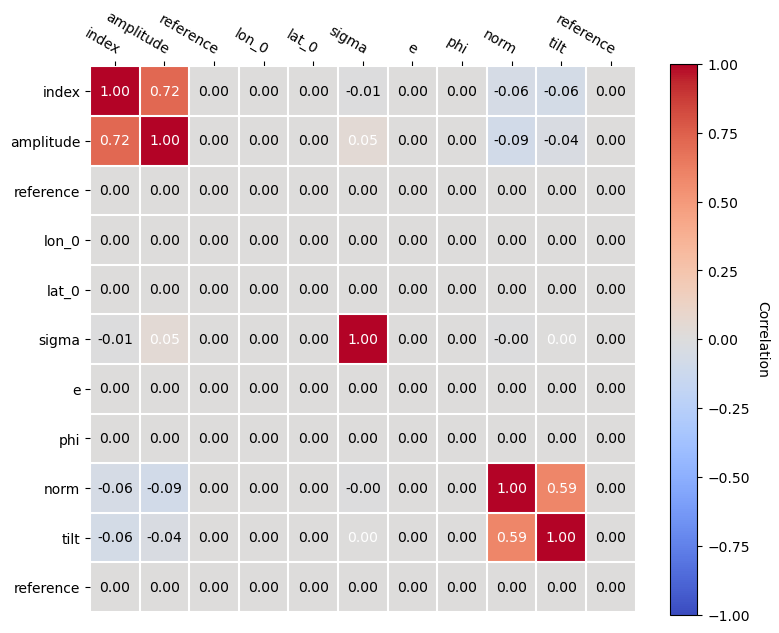

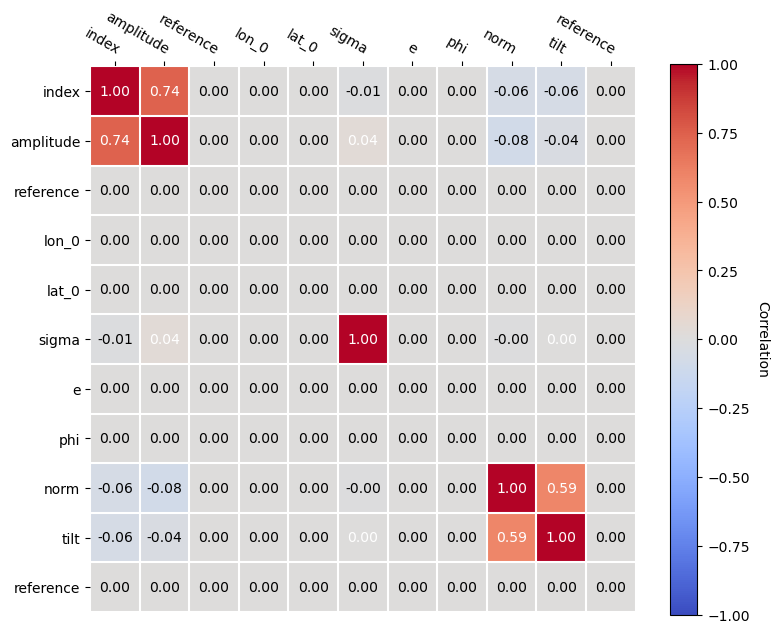

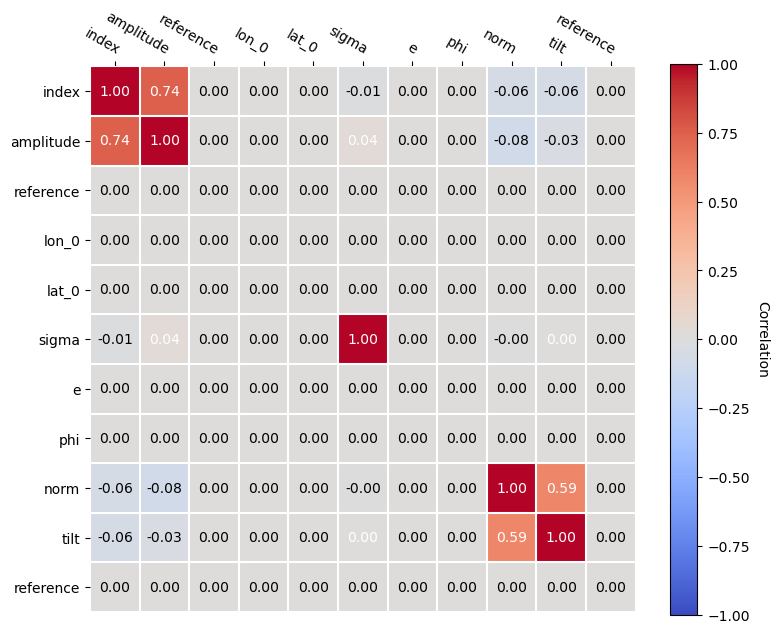

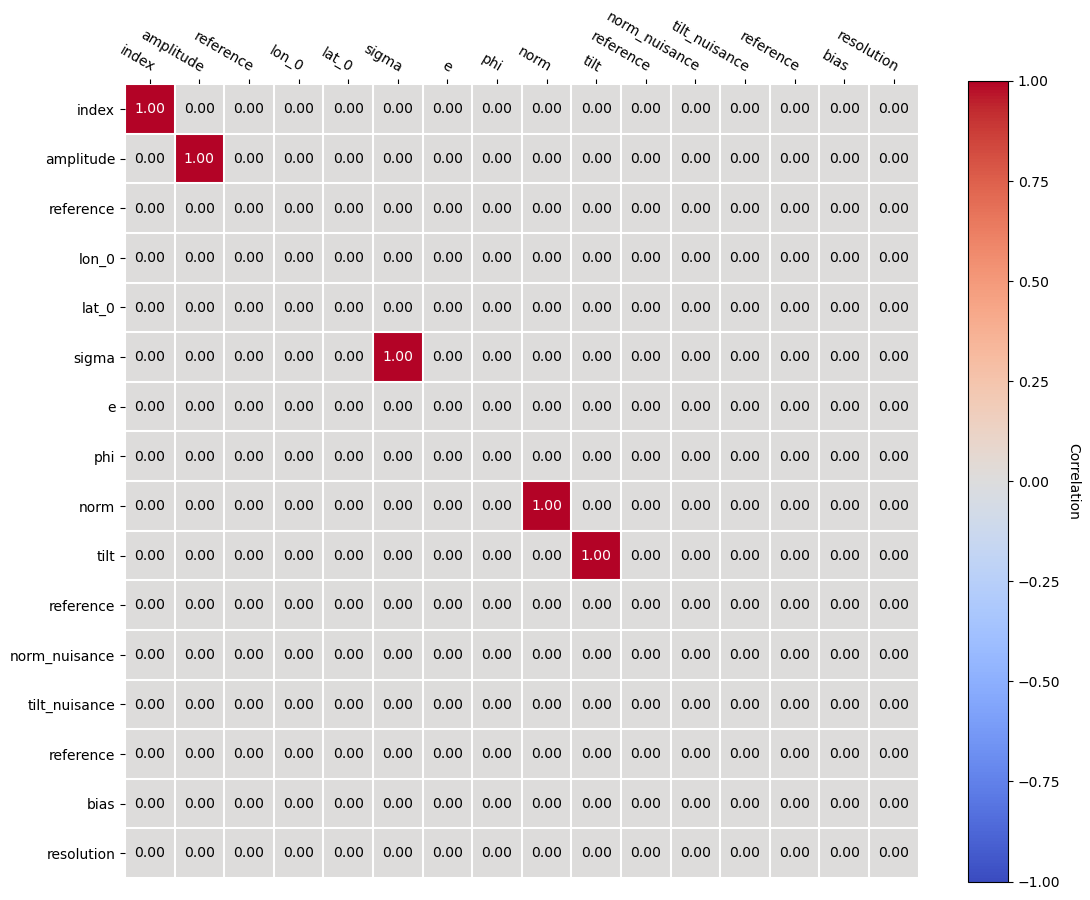

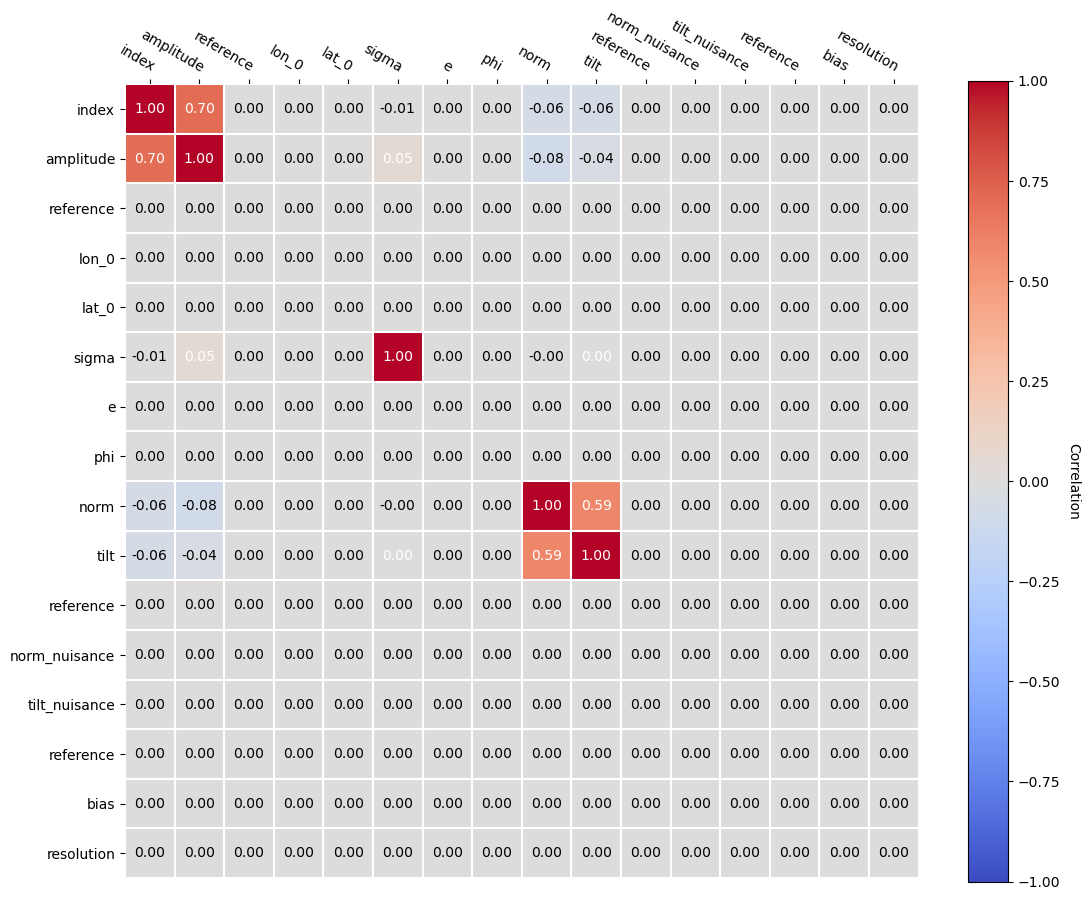

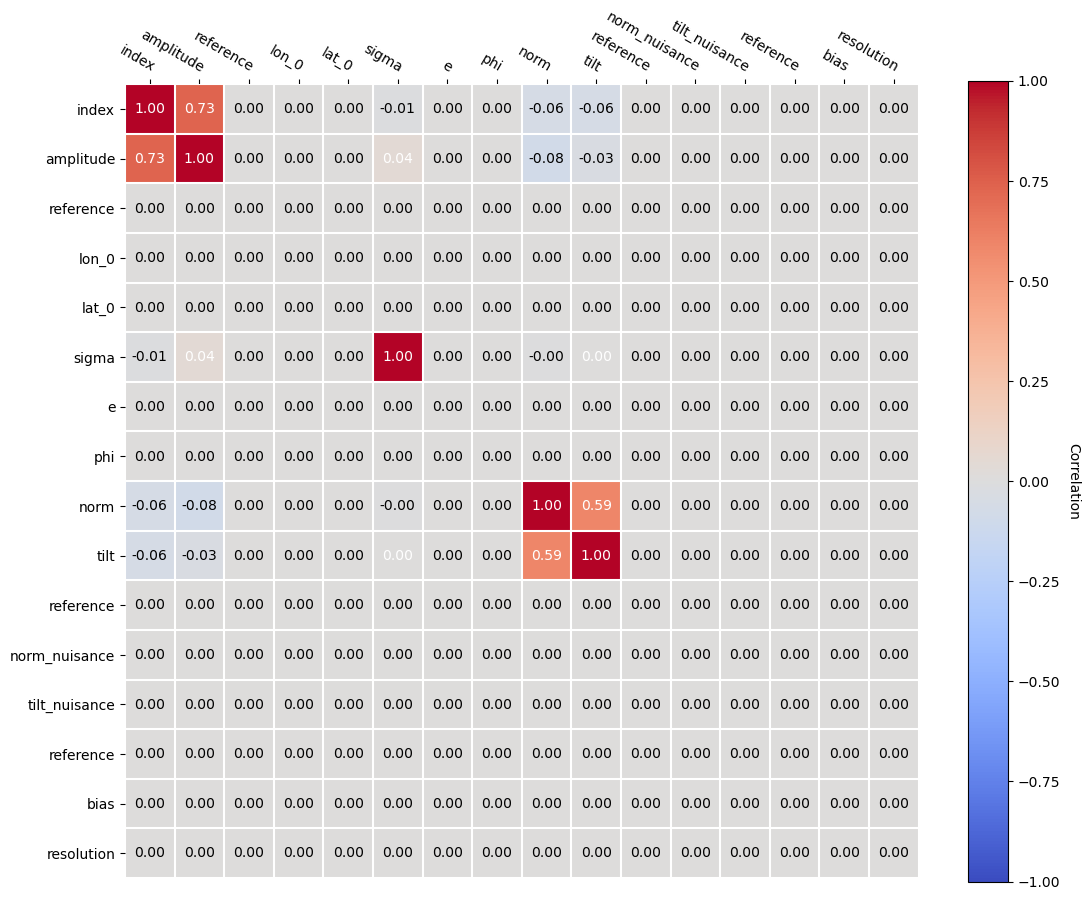

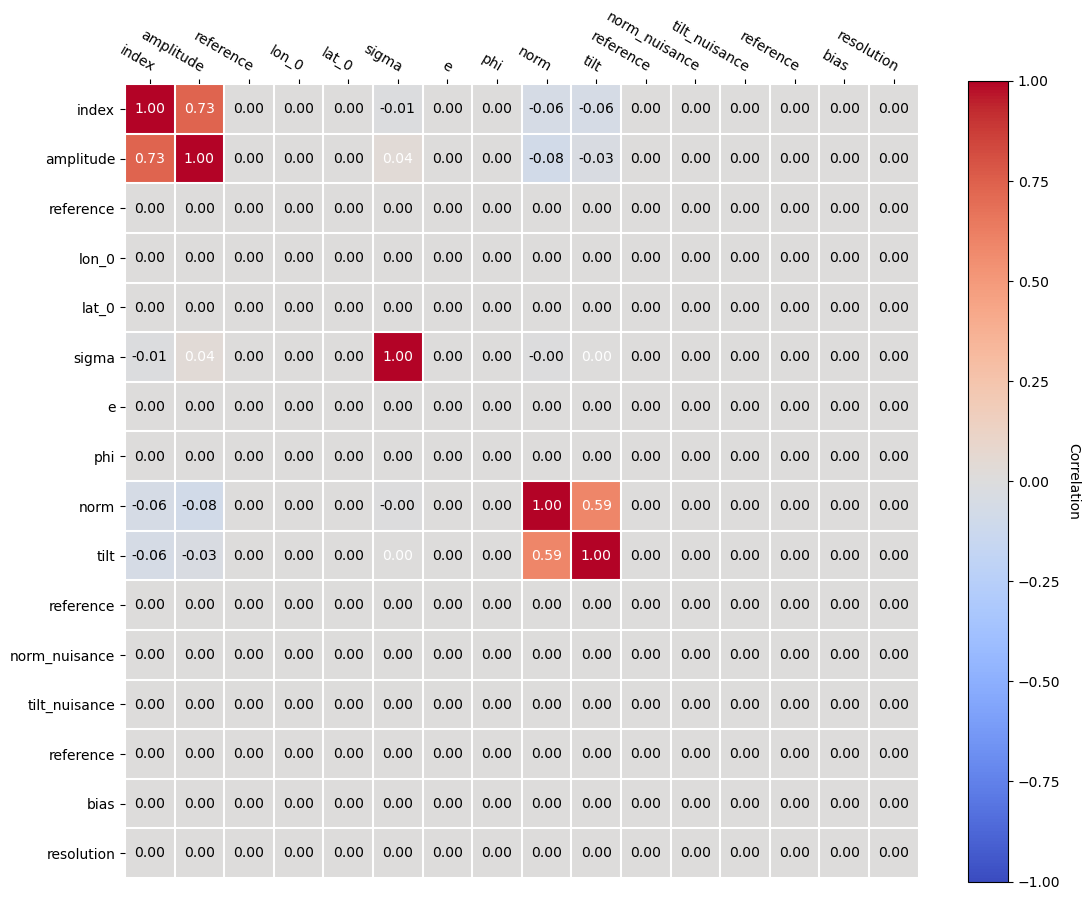

In [17]:
%%time
print("corr")
for d in datasets_conv:

    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(d)
    d.models.covariance = fit_cor.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
for d in datasets_conv_N:

    fit_cor_N = Fit(store_trace=True)
    fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N = fit_cor_N.run(d)
    d.models.covariance = fit_cor_N.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)

'''for d in datasets_conv_N_fine:
    fit_cor_N_fine = Fit(store_trace=True)
    fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N_fine = fit_cor_N_fine.run(d)
    d.models.covariance = fit_cor_N_fine.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor_N_fine.minuit)


'''
        

In [12]:
print(datasets_conv_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 9.0e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : _iHMQSGQ-bkg
  Datasets names            : ['_iHMQSGQ']
  Spectral model type       : PowerLawNormSpectralModel
  Parameter

In [13]:
for d in datasets_conv_N:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True
        print(p.name)
for p in datasets_conv_N_fine:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True
        print(p.name)

norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution
norm_nuisance
tilt_nuisance
bias
resolution


In [14]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


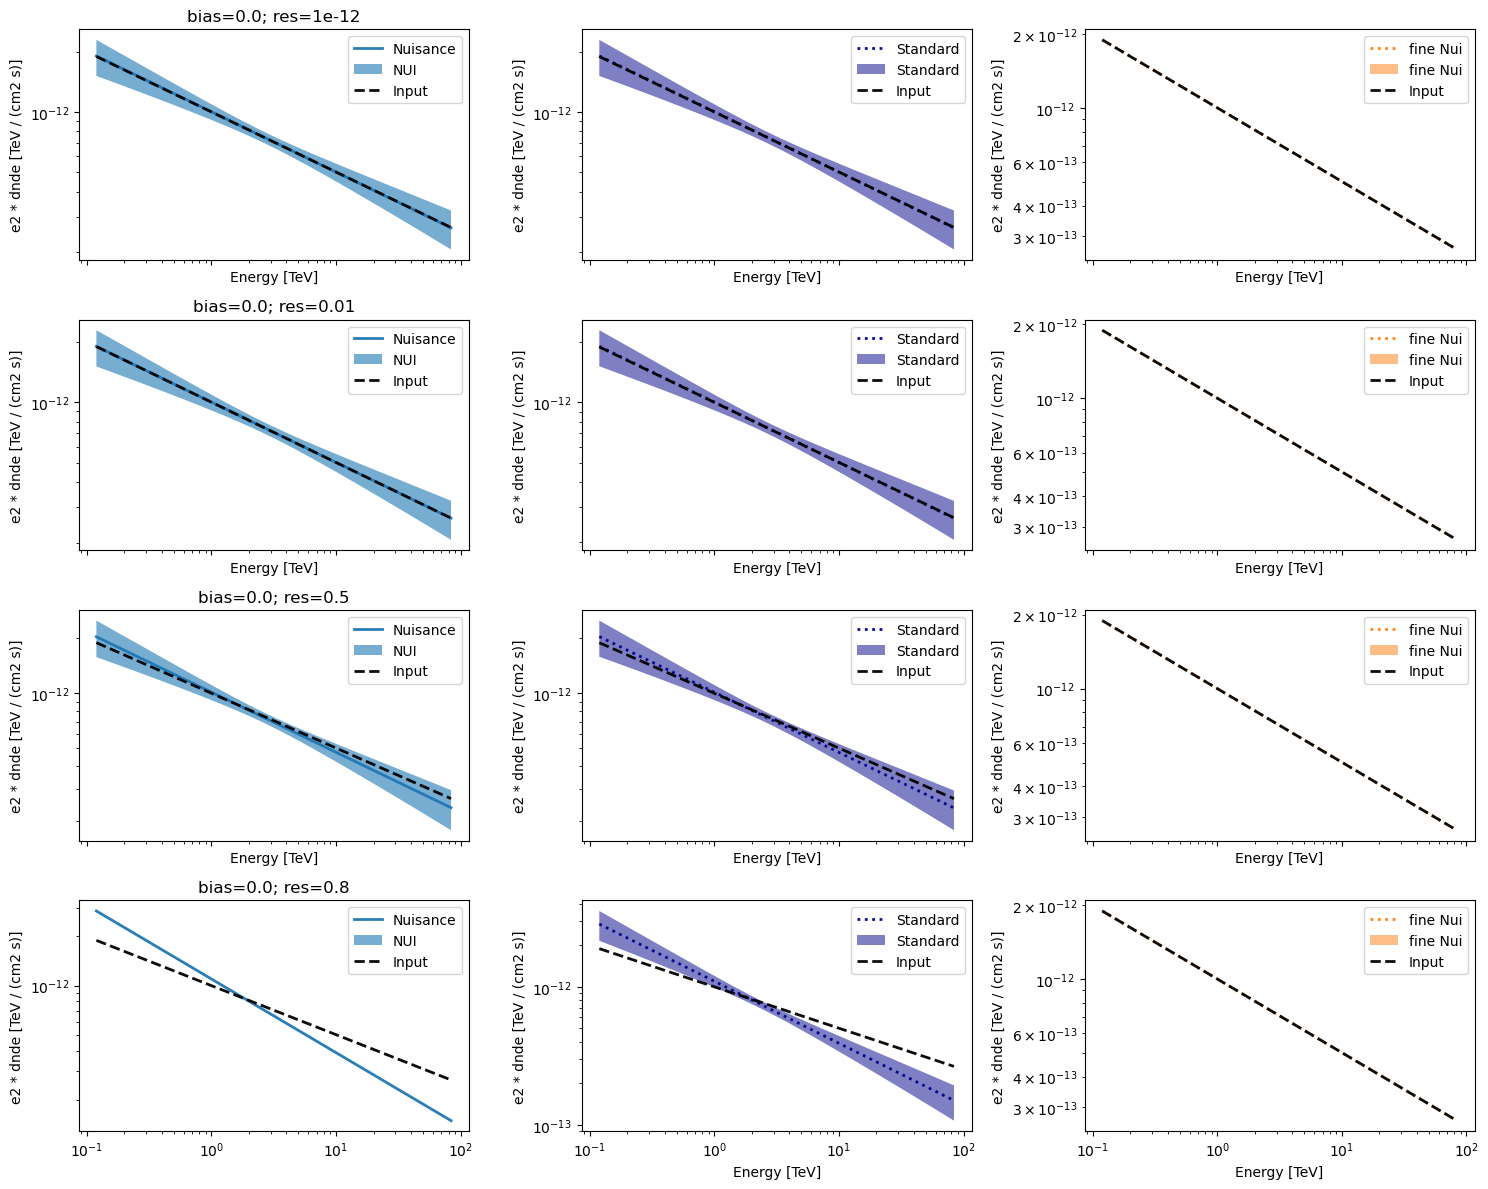

In [15]:


fig,axss = plt.subplots(4,3, sharex = True, sharey=False, figsize = (15,12
                                                                   ))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        ii = 0
        axs = axss[i]
        d = datasets_conv_N[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_standard[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        d = datasets_conv_N_fine[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               color=colors[ii+1],
                                                                 label= f"fine Nui",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               facecolor=colors[ii+1],
                                                                 label="fine Nui",
                                                                alpha = 0.5)
        
        axs[0].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for ass in axss:
    for a in ass:
        dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
        a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()


in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1


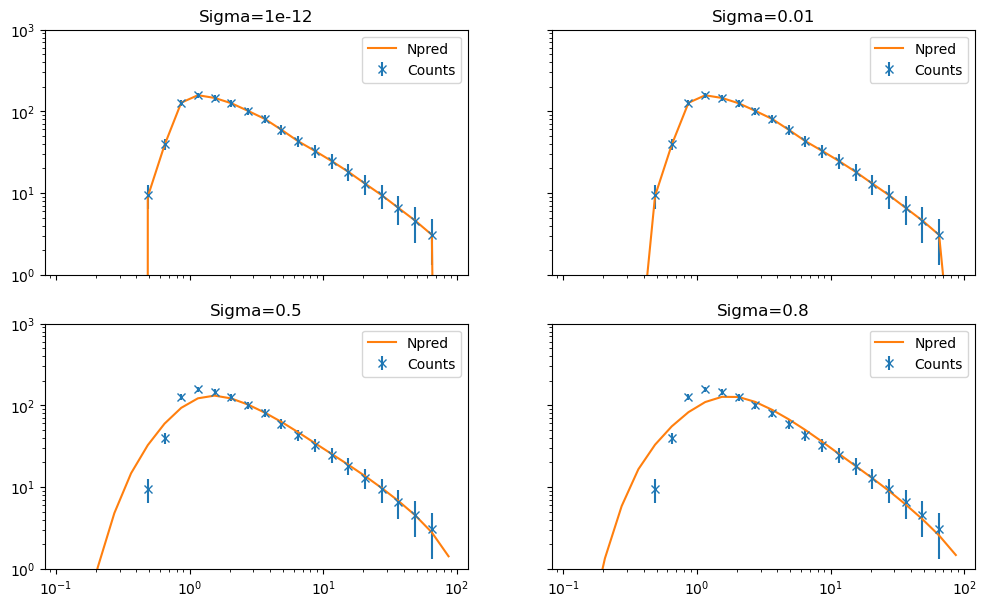

In [18]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_title(f"Sigma={s}")
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1
in map: -0.002038309598592452
evaluate: -0.002038309598592452 0.0
1


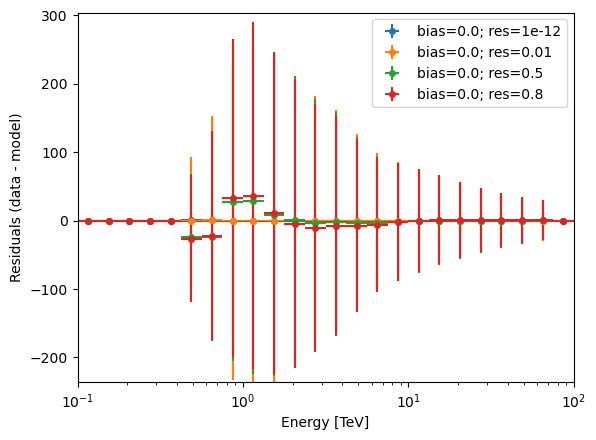

In [19]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


['B=0.0;\n R=1e-12\n Stan.', '\n N', 'B=0.0;\n R=0.01\n Stan.', '\n N', 'B=0.0;\n R=0.5\n Stan.', '\n N', 'B=0.0;\n R=0.8\n Stan.', '\n N']


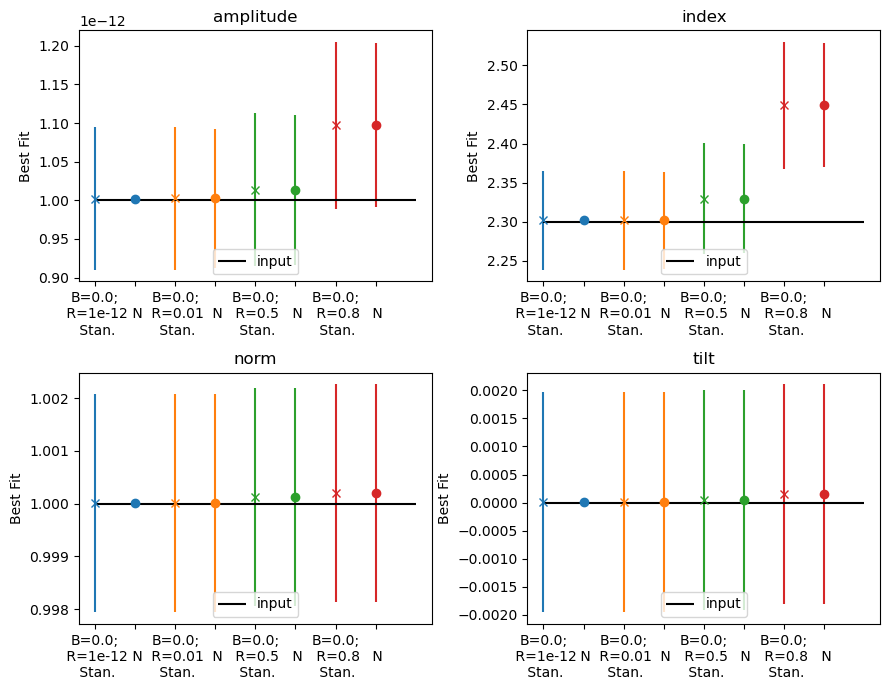

In [20]:
fig,ax  = plt.subplots(2,2,figsize= (9, 7))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = colors[ii])
        labels_sys.append(f'B={b};\n R={s}\n Stan.')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.5), value, yerr = error, fmt = 'o', color = colors[ii])
        labels_sys.append(f'\n N')
            
        #d = datasets_conv_N_fine[ii]
        #for i, p in enumerate(parnames):
        #    value = d.models.parameters[p].value
        #    error = d.models.parameters[p].error    
        #    ax[i].errorbar(2, value, yerr = error, fmt = 'x', color = colors[ii])
        #labels_sys.append(f'B={b};\n R={s};\n nbin =10')
            
        ii +=1
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)/2, label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys))*0.5,labels_sys)
    
plt.tight_layout()
    

In [28]:
datasets_conv_N[0].models.parameters['resolution'].value = 0.0
print(datasets_conv_N[0].models.parameters.to_table())

  type        name       value         unit        error      min        max    frozen is_norm is_penalised link
-------- ------------- ---------- -------------- --------- ---------- --------- ------ ------- ------------ ----
spectral         index 2.3014e+00                      nan        nan       nan  False   False        False     
spectral     amplitude 1.0023e-12 cm-2 s-1 TeV-1       nan        nan       nan  False    True        False     
spectral     reference 1.0000e+00            TeV 0.000e+00        nan       nan   True   False        False     
 spatial         lon_0 8.3631e+01            deg 0.000e+00        nan       nan   True   False        False     
 spatial         lat_0 2.2018e+01            deg 0.000e+00 -9.000e+01 9.000e+01   True   False        False     
 spatial         sigma 1.9177e-02            deg       nan  0.000e+00       nan  False   False        False     
 spatial             e 0.0000e+00                0.000e+00  0.000e+00 1.000e+00   True   False  

In [29]:
print(datasets_conv_N[1].models.parameters.to_table())

  type        name       value         unit        error      min        max    frozen is_norm is_penalised link
-------- ------------- ---------- -------------- --------- ---------- --------- ------ ------- ------------ ----
spectral         index 2.3017e+00                6.189e-02        nan       nan  False   False        False     
spectral     amplitude 1.0027e-12 cm-2 s-1 TeV-1 9.018e-14        nan       nan  False    True        False     
spectral     reference 1.0000e+00            TeV 0.000e+00        nan       nan   True   False        False     
 spatial         lon_0 8.3631e+01            deg 0.000e+00        nan       nan   True   False        False     
 spatial         lat_0 2.2018e+01            deg 0.000e+00 -9.000e+01 9.000e+01   True   False        False     
 spatial         sigma 1.9181e-02            deg 1.108e-02  0.000e+00       nan  False   False        False     
 spatial             e 0.0000e+00                0.000e+00  0.000e+00 1.000e+00   True   False  

['B=0.0;\n R=1e-12;', 'B=0.0;\n R=0.01;', 'B=0.0;\n R=0.5;', 'B=0.0;\n R=0.8;']


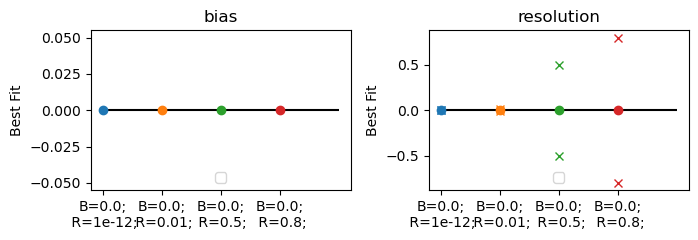

In [30]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)
            
            if p == 'resolution':
                ax[i].plot(ii, 1/np.sqrt(d.penalising_invcovmatrix[-1][-1]) , 'x', color = colors[ii])
                ax[i].plot(ii, -1/np.sqrt(d.penalising_invcovmatrix[-1][-1]) , 'x', color = colors[ii])
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    ax.hlines( 0, 0., len(labels_sys), label = "input", color= 'black')
    
plt.tight_layout()
    

In [31]:
ii = 0
sigma_values = np.linspace(-0.3,0.3, 30)

statss = []
for d in datasets_conv_N:
    s= []
    value = d.irf_model.parameters['resolution'].value 
    
    for v in sigma_values:
        d.irf_model.parameters['resolution'].value = v
        s.append(d.stat_sum())
        ii += 1
    d.irf_model.parameters['resolution'].value  = value
    
    statss.append(s)

in map: -0.3
evaluate: -0.3 0.0
1
in map: -0.2793103448275862
evaluate: -0.2793103448275862 0.0
1
in map: -0.2586206896551724
evaluate: -0.2586206896551724 0.0
1
in map: -0.2379310344827586
evaluate: -0.2379310344827586 0.0
1
in map: -0.21724137931034482
evaluate: -0.21724137931034482 0.0
1
in map: -0.19655172413793104
evaluate: -0.19655172413793104 0.0
1
in map: -0.17586206896551723
evaluate: -0.17586206896551723 0.0
1
in map: -0.15517241379310343
evaluate: -0.15517241379310343 0.0
1
in map: -0.13448275862068965
evaluate: -0.13448275862068965 0.0
1
in map: -0.11379310344827587
evaluate: -0.11379310344827587 0.0
1
in map: -0.09310344827586206
evaluate: -0.09310344827586206 0.0
1
in map: -0.07241379310344825
evaluate: -0.07241379310344825 0.0
1
in map: -0.051724137931034475
evaluate: -0.051724137931034475 0.0
1
in map: -0.031034482758620696
evaluate: -0.031034482758620696 0.0
1
in map: -0.010344827586206862
evaluate: -0.010344827586206862 0.0
1
in map: 0.010344827586206917
evaluate: 0.0

In [ ]:
fig, axs = plt.subplots(1,1)
axs = [axs]
for i, s in enumerate( statss):
    if i >1:
        plt.plot(sigma_values, s, label = sigmass[i])
    
    
axs[0].legend( loc='center left',  bbox_to_anchor=(1, 0.5))
axs[0].set_yscale("linear")

In [ ]:
fig, axs = plt.subplots(2,1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ii = 0
sigma_values = [0.0, 0.05, 0.1]
sigma_values = np.linspace(0,0.1, 3)
original_model_pred = sum_e(dataset_conv.npred_signal().data)
axs[0].plot(energy ,  original_model_pred, '-', color = 'grey', label=f'Original')

for v in sigma_values:
    dataset_conv_N.irf_model.parameters['resolution'].value = v
    dataset_conv_N_fine.irf_model.parameters['resolution'].value = v
    exp_1 = dataset_conv_N.npred_signal()    
    exp_10 = dataset_conv_N_fine.npred_signal()
    axs[0].plot(energy , sum_e(exp_1.data), ':', color = colors[ii], label=f'Nbins 1, simga={v:.2}')
    axs[0].plot(energy, sum_e(exp_10.data),'x', color = colors[ii],  label = f'Nbins 10, simga={v:.2}')
    axs[1].plot(energy , sum_e(exp_1.data) - original_model_pred , ':', color = colors[ii], label=f'Nbins 1, simga={v:.2}')
    axs[1].plot(energy, sum_e(exp_10.data) - original_model_pred, 'x', color = colors[ii], label = f'Nbins 10, simga={v:.2}')
    ii += 1

    
    
for a in axs:
    a.loglog()
    a.legend( loc='center left',  bbox_to_anchor=(1, 0.5))
    a.set_ylabel("Model Prediction")
    a.set_xlabel("Energy [TeV]")
axs[1].set_yscale("linear")

In [ ]:
stat_off = np.min(result_cor_N.trace['total_stat'].data)
print(stat_off)
plt.plot(result_cor_N.trace['dataset N-irf.None.resolution'].data, 
         result_cor_N.trace['total_stat'].data - stat_off, 'x')

plt.yscale('log')